# Model Interpretability
Created by: Pat Pascual

This notebook compares interpretability between our best Gradient Boosting model and a tuned Logistic Regression through:
1. Model Performance Comparison
2. Feature Importance Analysis
3. SHAP Values
4. Confusion Matrix Interpretation

In [22]:
!pip install shap

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
# general libraries
import re
import time
import json
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score)

# imbalanced techniques
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours,
                                     RepeatedEditedNearestNeighbours)
from imblearn.combine import SMOTETomek, SMOTEENN



In [40]:
# Split data into train-validation-holdout sets
X = clean.drop(['Response'], axis=1)
y = clean['Response']

# First split: separate holdout set (75% train+val, 25% holdout)
X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(
    X, y,
    test_size=0.25,  # 25% holdout
    random_state=11,
    stratify=y  # Maintain class distribution
)

In [41]:
def auto_ml(X_trainval, y_trainval, models_dict, cv=None, res_t=None):
    """Apply ML models with optional resampling"""
    from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
    results = {}
    
    # For each model
    for model_name, model in tqdm(models_dict.items()):
        model_start = time.time()
        
        # Initialize metric lists
        train_scores, val_scores = [], []
        train_recall, val_recall = [], []
        train_precision, val_precision = [], []
        train_f1, val_f1 = [], []
        train_roc_auc, val_roc_auc = [], []
        
        # For each fold
        for train_index, val_index in tqdm(cv.split(X_trainval, y_trainval)):
            X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
            y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

            # Apply resampling
            if res_t is not None:
                X_train, y_train = res_t.fit_resample(X_train, y_train)

            # Fit and predict
            model.fit(X_train, y_train)
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            # Get probability predictions for ROC AUC
            train_probs = model.predict_proba(X_train)[:,1]
            val_probs = model.predict_proba(X_val)[:,1]

            # Calculate metrics
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))
            train_recall.append(recall_score(y_train, train_preds, average='weighted'))
            val_recall.append(recall_score(y_val, val_preds, average='weighted'))
            train_precision.append(precision_score(y_train, train_preds, average='weighted'))
            val_precision.append(precision_score(y_val, val_preds, average='weighted'))
            train_f1.append(f1_score(y_train, train_preds, average='weighted'))
            val_f1.append(f1_score(y_val, val_preds, average='weighted'))
            train_roc_auc.append(roc_auc_score(y_train, train_probs))
            val_roc_auc.append(roc_auc_score(y_val, val_probs))

        # Store aggregated results
        results[model_name] = {
            'Train Accuracy': f"{np.mean(train_scores)*100:.2f}%",
            'Val Accuracy': f"{np.mean(val_scores)*100:.2f}%",
            'Train Recall': f"{np.mean(train_recall)*100:.2f}%", 
            'Train Precision': f"{np.mean(train_precision)*100:.2f}%",
            'Train F1': f"{np.mean(train_f1)*100:.2f}%",
            'Train ROC AUC': f"{np.mean(train_roc_auc):.3f}",
            'Train GINI': f"{2*np.mean(train_roc_auc)-1:.3f}",
            'Val Recall': f"{np.mean(val_recall)*100:.2f}%",
            'Val Precision': f"{np.mean(val_precision)*100:.2f}%",
            'Val F1': f"{np.mean(val_f1)*100:.2f}%",
            'Val ROC AUC': f"{np.mean(val_roc_auc):.3f}",
            'Val GINI': f"{2*np.mean(val_roc_auc)-1:.3f}",
            'Total Time': f"{time.time() - model_start:.2f}s"
        }

    return pd.DataFrame(results).T

## 1. Model Training and Optimization

In [42]:
# Train Logistic Regression
log_params = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear', 'saga']
}

log_grid = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    log_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Get best parameters
log_grid.fit(X_train, y_train)
print("Best parameters:", log_grid.best_params_)
print("Best score:", log_grid.best_score_)

Best parameters: {'C': 0.08858667904100823, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.8947137226425397


In [43]:
models_dict = {
    'LogisticRegressor': LogisticRegression(C=0.08858667904100823, 
                                          penalty='l2',
                                          solver='liblinear',
                                          random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05, 
        max_depth=4,
        min_samples_split=2,
        min_samples_leaf=2,
        subsample=1.0,
        random_state=42
    )
}

auto_run = auto_ml(X_trainval, y_trainval, models_dict,
                   cv=StratifiedKFold(n_splits=5))
# Display the results
display(auto_run)

auto_run = auto_ml(X_trainval, y_trainval, models_dict,
                   cv=StratifiedKFold(n_splits=5))
# Display the results
display(auto_run)

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Recall,Train Precision,Train F1,Train ROC AUC,Train GINI,Val Recall,Val Precision,Val F1,Val ROC AUC,Val GINI,Total Time
LogisticRegressor,90.51%,90.47%,90.51%,89.00%,88.93%,0.895,0.791,90.47%,88.94%,88.87%,0.895,0.790,0.49s
GradientBoostingClassifier,91.07%,90.60%,91.07%,89.85%,89.84%,0.916,0.831,90.60%,89.19%,89.29%,0.907,0.814,11.43s


In [50]:
# Get the best models from the auto_ml run
best_log = models_dict['LogisticRegressor']
best_gb = models_dict['GradientBoostingClassifier']

# Fit the models on the full training data
best_log.fit(X_trainval, y_trainval)
best_gb.fit(X_trainval, y_trainval)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, min_samples_leaf=2,
                           n_estimators=200, random_state=42)

## 2. Model Performance Comparison

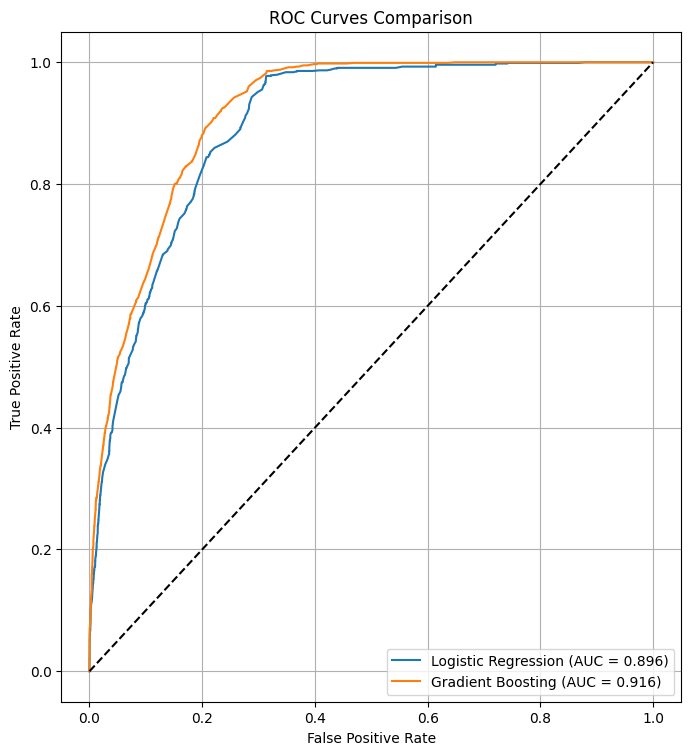


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7766
           1       0.65      0.30      0.41       982

    accuracy                           0.90      8748
   macro avg       0.78      0.64      0.68      8748
weighted avg       0.89      0.90      0.89      8748


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7766
           1       0.66      0.37      0.47       982

    accuracy                           0.91      8748
   macro avg       0.79      0.67      0.71      8748
weighted avg       0.89      0.91      0.90      8748



In [51]:
def plot_roc_curves(models, X, y):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(8, 8.7))
    
    for name, model in models.items():
        y_pred_proba = model.predict_proba(X)[:, 1]
        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Compare model performance
models = {
    'Logistic Regression': best_log,
    'Gradient Boosting': best_gb
}

# Plot ROC curves
plot_roc_curves(models, X_test, y_test)

# Print classification reports
for name, model in models.items():
    print(f"\n{name} Classification Report:")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

## 3. Feature Importance Comparison

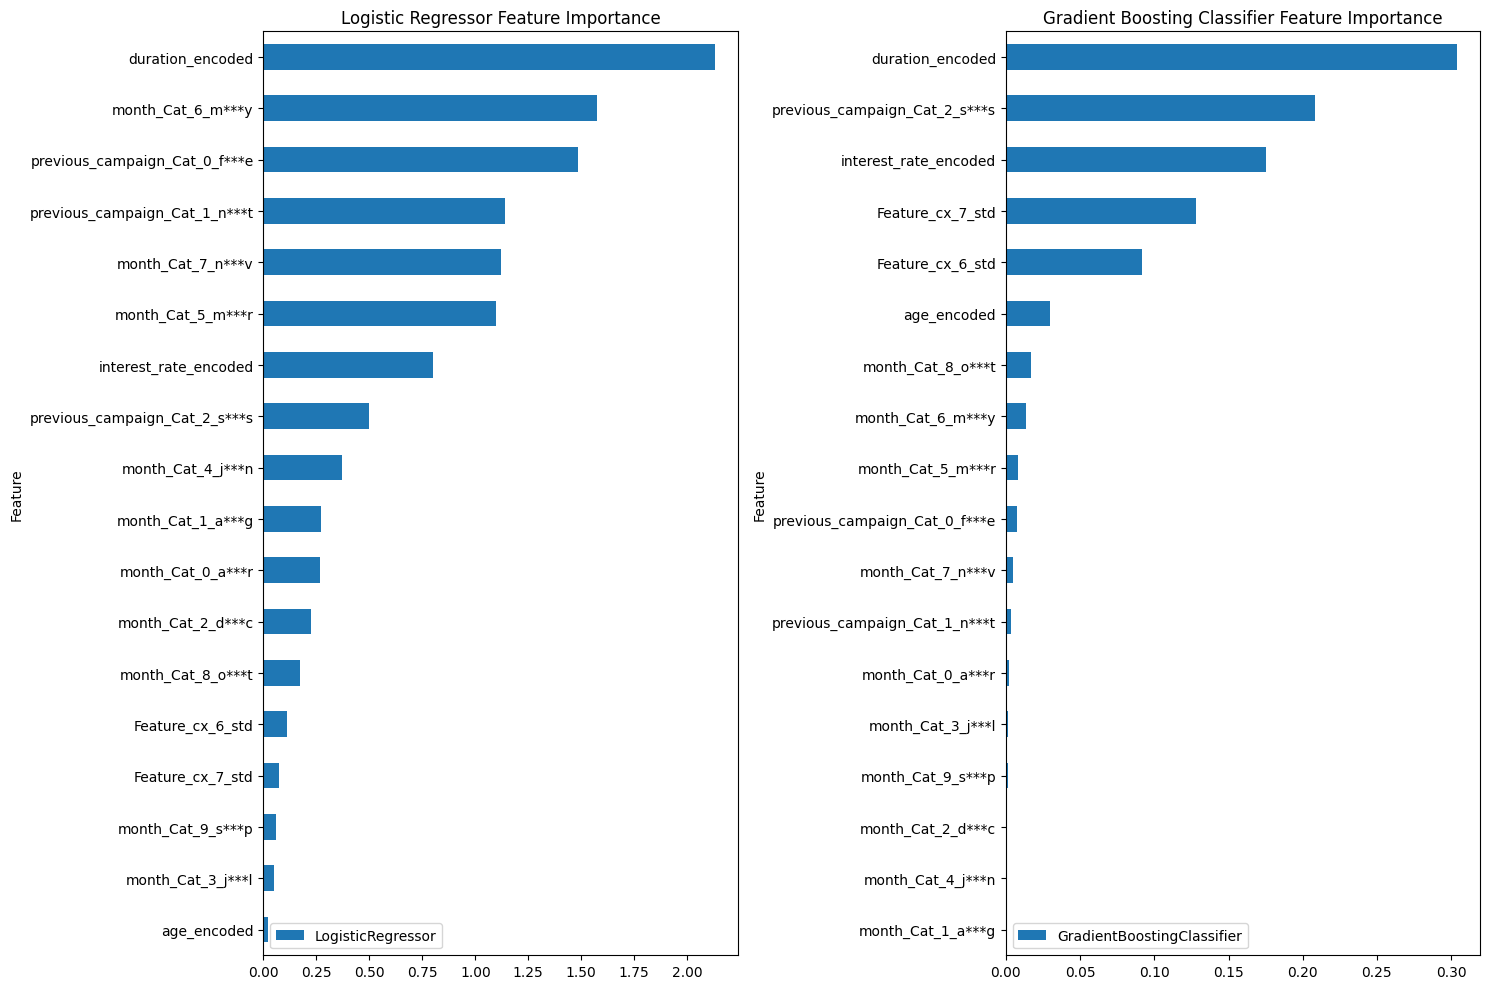

Top 10 Features by Model:

Logistic Regressor:
                          Feature  LogisticRegressor
16               duration_encoded           2.130692
8               month_Cat_6_m***y           1.576101
12  previous_campaign_Cat_0_f***e           1.482339
13  previous_campaign_Cat_1_n***t           1.140638
9               month_Cat_7_n***v           1.120658
7               month_Cat_5_m***r           1.098543
17          interest_rate_encoded           0.802192
14  previous_campaign_Cat_2_s***s           0.496226
6               month_Cat_4_j***n           0.372039
3               month_Cat_1_a***g           0.273676

Gradient Boosting Classifier:
                          Feature  GradientBoostingClassifier
16               duration_encoded                    0.304232
14  previous_campaign_Cat_2_s***s                    0.208240
17          interest_rate_encoded                    0.175359
1                Feature_cx_7_std                    0.128223
0                Feature_cx_6

In [52]:
def compare_feature_importance(log_model, gb_model, X, feature_names):
    """Compare feature importance between models"""
    # Get importances
    log_importance = np.abs(log_model.coef_[0])
    gb_importance = gb_model.feature_importances_
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'LogisticRegressor': log_importance,
        'GradientBoostingClassifier': gb_importance
    })
    
    # Sort by average importance
    importance_df['Average'] = importance_df[['LogisticRegressor', 'GradientBoostingClassifier']].mean(axis=1)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
    
    # Logistic Regression
    importance_df.sort_values('LogisticRegressor', ascending=True).plot(
        x='Feature', y='LogisticRegressor', kind='barh', ax=ax1
    )
    ax1.set_title('Logistic Regressor Feature Importance')
    
    # Gradient Boosting
    importance_df.sort_values('GradientBoostingClassifier', ascending=True).plot(
        x='Feature', y='GradientBoostingClassifier', kind='barh', ax=ax2
    )
    ax2.set_title('Gradient Boosting Classifier Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Compare feature importance
importance_comparison = compare_feature_importance(best_log, best_gb, X_train, X.columns)

# Print top 10 features for each model
print("Top 10 Features by Model:")
print("\nLogistic Regressor:")
print(importance_comparison.nlargest(10, 'LogisticRegressor')[['Feature', 'LogisticRegressor']])
print("\nGradient Boosting Classifier:")
print(importance_comparison.nlargest(10, 'GradientBoostingClassifier')[['Feature', 'GradientBoostingClassifier']])

## 4. SHAP Value Analysis

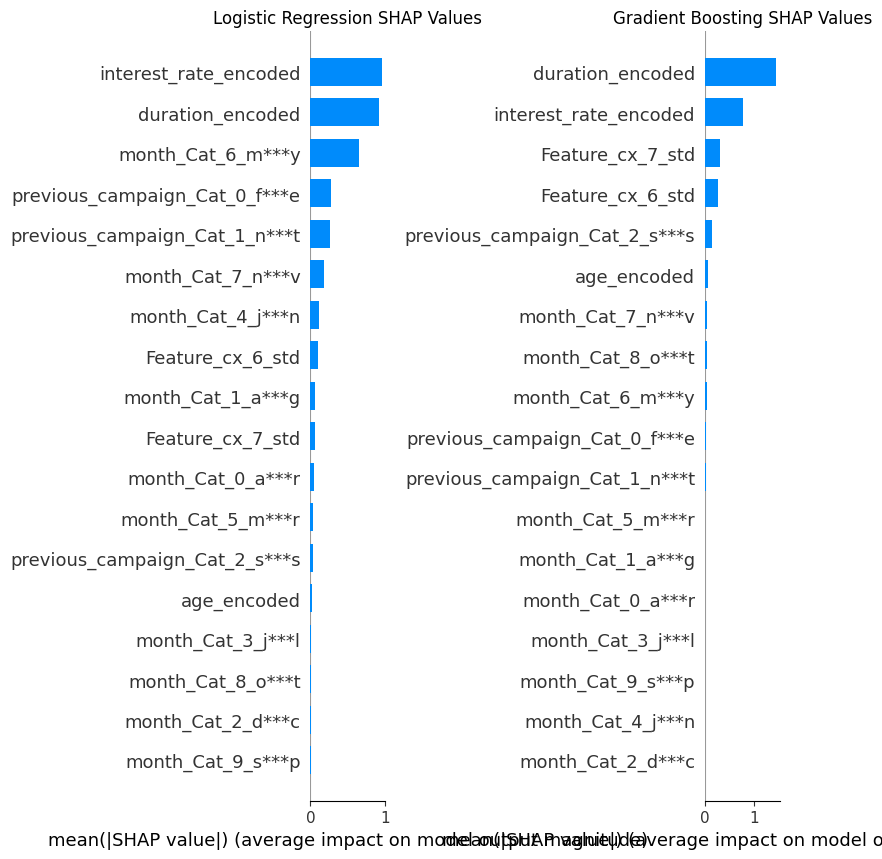

In [53]:
# Calculate SHAP values for both models
# Logistic Regression SHAP
log_explainer = shap.LinearExplainer(best_log, X_train)
log_shap_values = log_explainer.shap_values(X_test)

# Gradient Boosting SHAP
gb_explainer = shap.TreeExplainer(best_gb)
gb_shap_values = gb_explainer.shap_values(X_test)

# Plot SHAP summary plots
plt.figure(figsize=(12, 6))
plt.subplot(121)
shap.summary_plot(log_shap_values, X_test, plot_type="bar", show=False)
plt.title("Logistic Regression SHAP Values")

plt.subplot(122)
shap.summary_plot(gb_shap_values, X_test, plot_type="bar", show=False)
plt.title("Gradient Boosting SHAP Values")

plt.tight_layout()
plt.show()

## 5. Confusion Matrix Comparison

In [54]:
def plot_confusion_matrices(models, X, y):
    """Plot confusion matrices for multiple models"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    for idx, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X)
        cm = confusion_matrix(y, y_pred)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[idx], cmap='Blues')
        axes[idx].set_title(f'{name} Confusion Matrix')
        
        # Calculate confusion matrix values
        tn, fp, fn, tp = cm.ravel()
        total = tn + fp + fn + tp
        
        print(f"\n{name} Confusion Matrix Details:")
        print(f"True Negatives: {tn} ({tn/total*100:.1f}%)")
        print(f"False Positives: {fp} ({fp/total*100:.1f}%)")
        print(f"False Negatives: {fn} ({fn/total*100:.1f}%)")
        print(f"True Positives: {tp} ({tp/total*100:.1f}%)")
    
    plt.tight_layout()
    plt.show()


Logistic Regression Confusion Matrix Details:
True Negatives: 7604 (86.9%)
False Positives: 162 (1.9%)
False Negatives: 683 (7.8%)
True Positives: 299 (3.4%)

Gradient Boosting Confusion Matrix Details:
True Negatives: 7575 (86.6%)
False Positives: 191 (2.2%)
False Negatives: 619 (7.1%)
True Positives: 363 (4.1%)


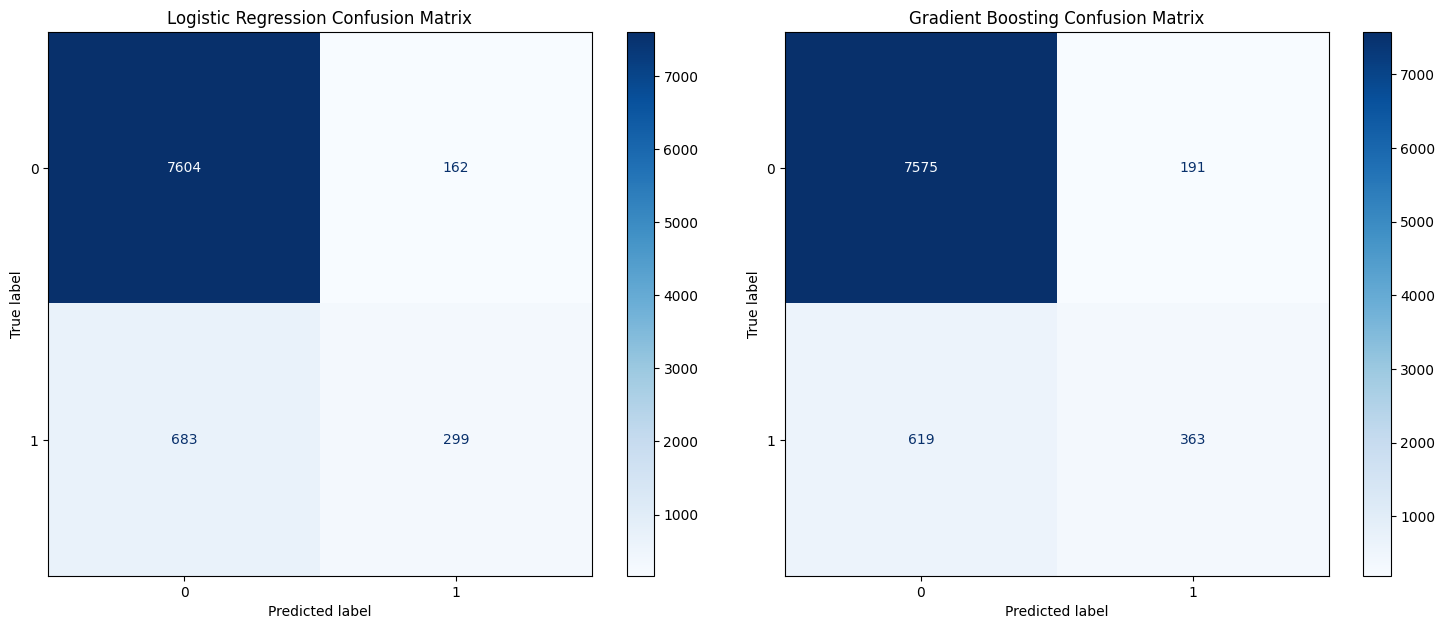

In [55]:
# Plot confusion matrices for both models
models = {
    'Logistic Regression': best_log,
    'Gradient Boosting': best_gb
}

plot_confusion_matrices(models, X_test, y_test)

## Confusion Matrix Analysis

Both models show strong performance in identifying non-churned customers (true negatives), with similar rates around 87%. However, there are some key differences:

### Logistic Regression
- Very high true negative rate (86.9%) - accurately identifies non-churning customers
- Low false positive rate (1.9%) - rarely misidentifies loyal customers as churners  
- Higher false negative rate (7.8%) - misses some actual churners
- Lower true positive rate (3.4%) - less effective at identifying actual churners

### Gradient Boosting
- Similarly high true negative rate (86.6%)
- Slightly higher false positive rate (2.2%) - more likely to raise false alarms
- Lower false negative rate (7.1%) - better at catching potential churners
- Higher true positive rate (4.1%) - more effective at identifying actual churners

### Key Takeaways
- Gradient Boosting shows better performance in identifying churners (higher true positive rate)
- This comes at a small cost of more false positives
- Both models are very reliable at identifying loyal customers
- The tradeoff between false positives and false negatives should be considered based on business costs


## 6. Model Interpretation Summary

### Performance Comparison
- While Gradient Boosting shows slightly better metrics (ROC AUC: 0.907 vs 0.895), 
  the marginal improvement may not justify the added complexity
- Logistic Regression offers comparable performance with significantly faster 
  training time (0.49s vs 11.43s)
- The simpler model architecture of Logistic Regression makes it easier to 
  interpret, deploy, and maintain

## Feature Importance Analysis

### Common Important Features
- `duration_encoded` is the most important feature for both models by a significant margin
- Both models consider `previous_campaign_Cat_2` and `interest_rate_encoded` as important features
- The relative importance of features differs between models

| Model Comparison | Logistic Regression | Gradient Boosting |
|-----------------|---------------------|-------------------|
| Distribution Pattern | More balanced across features | Concentrated in fewer features |
| Value Range | ~0.2 to 2.1 | ~0.007 to 0.3 |
| Top Features | - Duration encoded<br>- Month categories (6,7,5)<br>- Previous campaign (0,1) | - Duration encoded<br>- Previous campaign Cat 2<br>- Interest rate encoded |
| Notable Characteristics | - Higher importance of temporal features<br>- More evenly distributed importance | - Technical features in top 5<br>- Sharper dropoff in importance<br>- Higher importance of age_encoded |

### Business Implications

1. **Key Predictors**
   - Call duration is consistently the strongest predictor across both models
   - Interest rates and previous campaign outcomes show high importance

2. **Model-Specific Insights**
   - Gradient Boosting captures more complex relationships in technical features
   - Temporal patterns (months) show stronger linear relationships in Logistic Regression
   - Feature importance distribution suggests Gradient Boosting may be identifying more subtle patterns